# What is the right price to pay for a used car?

The biggest dilemma facing a customer in the market for a used car is "what is a fair price for this car". This question is more significant with a used car purchase than a new car as there is no standard MSRP associated with the make, model, and year as with a new car. 

In addition, used cars sold by private parties bring more uncertainly in pricing and quality into the mix making it a risky transaction. While it we will not address the legal risks, we can certainly take on the pricing problem. 

In this project we will use the historical prices of used cars in Europe to device a model that would let a used car buy estimate the price he would expect to pay based on the main (yet basic) features of used cars. 

The source of historical used car price data employed in this project was obtained from: https://www.kaggle.com/datasets/sanskrutipanda/car-pricing-prediction

In [39]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector, RFE

import numpy as np
import matplotlib.pyplot as plt

In [40]:
cars = pd.read_csv('cars_sampled.csv')

In [41]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dateCrawled          50001 non-null  object
 1   name                 50001 non-null  object
 2   seller               50001 non-null  object
 3   offerType            50001 non-null  object
 4   price                50001 non-null  int64 
 5   abtest               50001 non-null  object
 6   vehicleType          44813 non-null  object
 7   yearOfRegistration   50001 non-null  int64 
 8   gearbox              47177 non-null  object
 9   powerPS              50001 non-null  int64 
 10  model                47243 non-null  object
 11  kilometer            50001 non-null  int64 
 12  monthOfRegistration  50001 non-null  int64 
 13  fuelType             45498 non-null  object
 14  brand                50001 non-null  object
 15  notRepairedDamage    40285 non-null  object
 16  date

# Data Cleanup and Inspection

## Drop null value data

In [42]:
cars = cars.dropna()

In [43]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35107 entries, 1 to 50000
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dateCrawled          35107 non-null  object
 1   name                 35107 non-null  object
 2   seller               35107 non-null  object
 3   offerType            35107 non-null  object
 4   price                35107 non-null  int64 
 5   abtest               35107 non-null  object
 6   vehicleType          35107 non-null  object
 7   yearOfRegistration   35107 non-null  int64 
 8   gearbox              35107 non-null  object
 9   powerPS              35107 non-null  int64 
 10  model                35107 non-null  object
 11  kilometer            35107 non-null  int64 
 12  monthOfRegistration  35107 non-null  int64 
 13  fuelType             35107 non-null  object
 14  brand                35107 non-null  object
 15  notRepairedDamage    35107 non-null  object
 16  date

## Inspect Data Range and Values for feature selection

In [44]:
cars['seller'].value_counts()

private       35106
commercial        1
Name: seller, dtype: int64

In [45]:
cars['offerType'].value_counts()

offer      35106
request        1
Name: offerType, dtype: int64

In [46]:
cars['abtest'].value_counts()

test       18161
control    16946
Name: abtest, dtype: int64

In [47]:
cars['vehicleType'].value_counts()

limousine        10378
small car         7994
station wagon     7137
bus               3315
cabrio            2443
coupe             1981
suv               1628
others             231
Name: vehicleType, dtype: int64

In [48]:
cars['yearOfRegistration'].max()

2018

In [49]:
cars['yearOfRegistration'].min()

1929

In [50]:
cars['gearbox'].value_counts()

manual       26895
automatic     8212
Name: gearbox, dtype: int64

In [51]:
cars['powerPS'].value_counts()

75     2276
150    1575
60     1466
140    1466
0      1328
       ... 
383       1
212       1
390       1
9         1
386       1
Name: powerPS, Length: 392, dtype: int64

In [52]:
cars['model'].value_counts()

golf          2758
others        2629
3er           2129
polo          1191
corsa         1117
              ... 
move             1
serie_3          1
serie_2          1
b_max            1
rangerover       1
Name: model, Length: 245, dtype: int64

In [53]:
cars['fuelType'].value_counts()

petrol     22888
diesel     11547
lpg          557
cng           67
hybrid        31
electro       10
other          7
Name: fuelType, dtype: int64

In [54]:
cars['brand'].value_counts()

volkswagen       7220
bmw              4112
mercedes_benz    3646
opel             3514
audi             3377
ford             2325
renault          1626
peugeot          1097
fiat              820
seat              694
skoda             596
mazda             541
nissan            502
citroen           494
toyota            479
smart             464
volvo             376
mini              370
hyundai           361
mitsubishi        281
porsche           266
honda             243
kia               238
suzuki            220
alfa_romeo        205
chevrolet         176
chrysler          149
dacia             106
subaru             93
jeep               79
land_rover         70
jaguar             64
saab               59
daihatsu           58
daewoo             51
lancia             44
rover              37
trabant            33
lada               21
Name: brand, dtype: int64

In [55]:
cars['notRepairedDamage'].value_counts()

no     31324
yes     3783
Name: notRepairedDamage, dtype: int64

In [56]:
cars['price'].max()

12345678

In [57]:
cars['price'].min()

0

In [58]:
cars['price'].value_counts().sort_values()

175000      1
23700       1
8666        1
4889        1
19290       1
         ... 
1200      377
2500      393
500       424
0         444
1500      469
Name: price, Length: 2155, dtype: int64

## Features we will not use

To mitigate the 'Curse of Dimensionality' we will do away with feature that we do not expect to contribute to our model. We will drop the following feature for the reasons cited.

1. **Seller**: All but one car are sold by private sellers and hence this feature is insignificant to our model
2. **OfferType**: This again has all but one vehicle in the 'offered' category and hence can be discarded
3. **abtest**: This feature has two classes with the number of cars almost evenly split between the two and hence can be dropped
4. **notRepairedDamage**: This two-class feature has only about 10% in one of the classes and hence ignored

In [59]:
X = cars[['vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'kilometer', 'model', 'brand', 
              'fuelType', 'postalCode']]

X.head()

,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,model,brand,fuelType,postalCode
1,suv,2005,manual,163,150000,xc_reihe,volvo,diesel,88045
3,small car,2006,manual,86,60000,ibiza,seat,petrol,34537
4,suv,2008,automatic,185,150000,xc_reihe,volvo,diesel,55270
5,limousine,1995,manual,90,150000,passat,volkswagen,petrol,26826
7,coupe,1997,manual,136,150000,clk,mercedes_benz,petrol,13353


# Preprocessing

For non-numeric features we will pick **LabelEncoder** and **OneHotEncoder** to convert them to numeric.

1. **LabelEncoder**: We will use this encoder for features vehicleType, model, brand and fuelType in order to keep the dimensions from exploding as it would with OneHotEncoder as these are multi valued classes.
2. **OneHotEncoder**: We will use OneHotEncoder just for the gearbox feature as it is binary and we will use this by setting 'drop if binary' to true.

In [60]:
pd.options.mode.chained_assignment = None  # supress warnings as assignment without copy is intended

X['vehicleType'] = LabelEncoder().fit_transform(cars['vehicleType'])
X['model'] = LabelEncoder().fit_transform(cars['model'])
X['brand'] = LabelEncoder().fit_transform(cars['brand'])
X['fuelType'] = LabelEncoder().fit_transform(cars['fuelType'])

X.head()

,vehicleType,yearOfRegistration,gearbox,powerPS,kilometer,model,brand,fuelType,postalCode
1,7,2005,manual,163,150000,239,38,1,88045
3,5,2006,manual,86,60000,118,30,6,34537
4,7,2008,automatic,185,150000,239,38,1,55270
5,3,1995,manual,90,150000,167,37,6,26826
7,2,1997,manual,136,150000,75,20,6,13353


In [61]:
y = cars['price']

In [62]:
y.value_counts().sort_values()

175000      1
23700       1
8666        1
4889        1
19290       1
         ... 
1200      377
2500      393
500       424
0         444
1500      469
Name: price, Length: 2155, dtype: int64

# Split Data into Train and Test 

We will use an **80-200 train-test split** to train our model and then test the model for it's efficiency. Further we will randomize it as well to disperse any unintended order of data in the source. 

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28085 entries, 39504 to 22551
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   vehicleType         28085 non-null  int64 
 1   yearOfRegistration  28085 non-null  int64 
 2   gearbox             28085 non-null  object
 3   powerPS             28085 non-null  int64 
 4   kilometer           28085 non-null  int64 
 5   model               28085 non-null  int64 
 6   brand               28085 non-null  int64 
 7   fuelType            28085 non-null  int64 
 8   postalCode          28085 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 2.1+ MB


# Modeling

We will now employ different models for supervised learning and measure their efficacy before picking one of them.

In [65]:
# ['vehicleType', 'model', 'brand', 'fuelType']
col_transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['gearbox']), 
                        remainder='passthrough')

In [66]:
# a function that takes the best estimator and computes feature importance and displays them

def compute_importance (best_est, X_test, y_test, repeats, num_cols=5):
    imp = permutation_importance(best_est, X_test, y_test, n_repeats=repeats, random_state=0)
    
    # Print feature importances
    print('Feature Importances')
    print('-------------------')
    # print the importance means
    for i in imp.importances_mean.argsort()[::-1]:
            print(f"{X_test.columns[i]:<8} "
               f"{imp.importances_mean[i]:.3f}"
               f" +/- {imp.importances_std[i]:.3f}")
    
    # print estimator score and MSE
    print(' ')
    print(f'Estimator Score:', best_est.score(X_test, y_test))
    mse = mean_squared_error(y_test, best_est.predict(X_test))
    print(f'Prediction Error (MSE)', mse)
    
    # also display it visually
    feature_importances = pd.Series(imp.importances_mean, index=X_test.columns).sort_values(ascending=False)
    feature_importances = feature_importances.iloc[:num_cols]
    
    fig, ax = plt.subplots()
    feature_importances.plot.bar()
    
    ax.set_title("Importance of Features in Determining Used Car Sale Price")
    ax.set_ylabel("Importance Mean")
    ax.set_xlabel("Used Car Features")
    fig.tight_layout()

## Linear Regression with Grid Search on Ploynomial Features

In [67]:
# Linear Regression

pipe = Pipeline([('transformer', col_transformer),
                    ("poly", PolynomialFeatures(include_bias=False)),
                    ("linreg", LinearRegression())])

# Use grid search to find optimal poly degree
param_dict = {'poly__degree': [1, 2, 3, 4]}
grid_lin = GridSearchCV(estimator=pipe, param_grid=param_dict)
grid_lin.fit(X_train, y_train)



GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['gearbox'])])),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('linreg', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3, 4]})

### Observations

Below are the 5 features in their order of impact on the price of the used car using this model.

Feature Importances
-------------------
kilometer 0.483 +/- 0.009
fuelType 0.081 +/- 0.003
powerPS  0.064 +/- 0.002
gearbox  0.056 +/- 0.003
vehicleType 0.008 +/- 0.001
brand    0.004 +/- 0.001
postalCode 0.000 +/- 0.000
model    -0.001 +/- 0.001
yearOfRegistration -0.026 +/- 0.003
 
Estimator Score: 0.2756885413023865
Prediction Error (MSE) 71455644.27700032


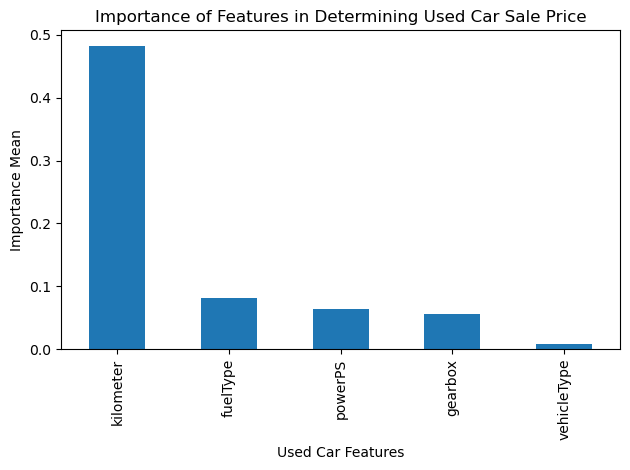

In [68]:
compute_importance(grid_lin.best_estimator_, X_test, y_test, 30)

## Sequential Feature Selection with Grid Search for Optimal number of features

### Observations

Below are the 5 features in their order of impact on the price of the used car using this model.

Feature Importances
-------------------
kilometer 0.375 +/- 0.008
powerPS  0.064 +/- 0.002
gearbox  0.059 +/- 0.003
fuelType 0.047 +/- 0.002
vehicleType 0.009 +/- 0.001
postalCode 0.000 +/- 0.000
brand    0.000 +/- 0.000
model    0.000 +/- 0.000
yearOfRegistration 0.000 +/- 0.000
 
Estimator Score: 0.31824289553630014
Prediction Error (MSE) 67257520.99445061


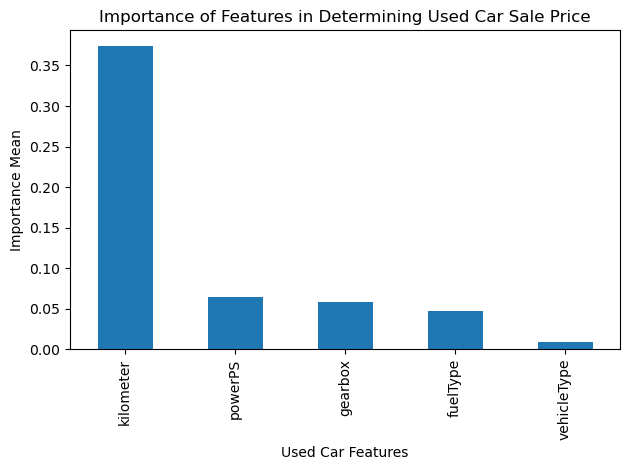

In [69]:
selector_pipe = Pipeline([('transformer', col_transformer),
                    ('selector', SequentialFeatureSelector(LinearRegression())),
                    ('model', LinearRegression())])

param_dict = {"selector__n_features_to_select":[2,3,4,5]}
selector_grid = GridSearchCV(estimator=selector_pipe, param_grid=param_dict)

selector_grid.fit(X_train, y_train)

best_estimator = selector_grid.best_estimator_
compute_importance(best_estimator, X_test, y_test, 30)

## Ridget with Grid Search to choose optimal Alpha

### Observations

Below are the 5 features in their order of impact on the price of the used car using this model.

Feature Importances
-------------------
kilometer 0.485 +/- 0.009
fuelType 0.084 +/- 0.003
powerPS  0.067 +/- 0.002
gearbox  0.046 +/- 0.003
vehicleType 0.008 +/- 0.001
brand    0.005 +/- 0.001
postalCode 0.000 +/- 0.000
model    -0.001 +/- 0.001
yearOfRegistration -0.026 +/- 0.003
 
Estimator Score: 0.2747286023047253
Prediction Error (MSE) 71550345.33235548


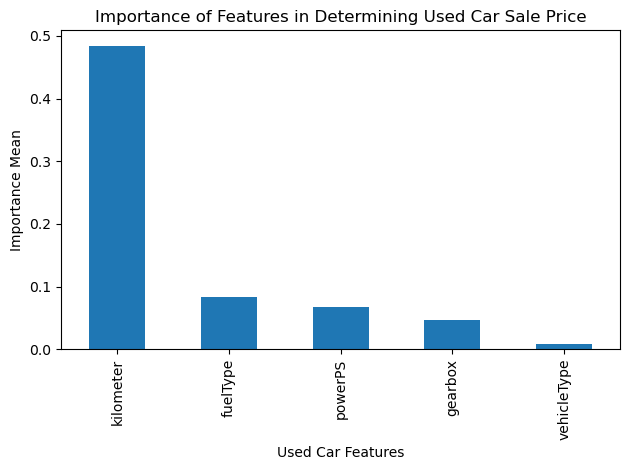

In [70]:
ridge_pipe = Pipeline([('transformer', col_transformer),
                    ("scaler", StandardScaler()),
                    ('Ridge', Ridge())])
params_dict = {"Ridge__alpha":[1e-10, 0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

ridge_grid = GridSearchCV(ridge_pipe, param_grid=params_dict)
ridge_grid.fit(X_train, y_train)

best_ridge = ridge_grid.best_estimator_.named_steps['Ridge']

trans_pipe = Pipeline([('transformer', col_transformer), 
                ('regressor', TransformedTargetRegressor(regressor=best_ridge))])
trans_pipe.fit(X_train, y_train)

compute_importance(trans_pipe, X_test, y_test, 30)

## RFE with Lasso Estimator

### Observations

Below are the 5 features in their order of impact on the price of the used car using this model.

Feature Importances
-------------------
kilometer 0.483 +/- 0.009
fuelType 0.082 +/- 0.003
powerPS  0.064 +/- 0.002
gearbox  0.056 +/- 0.003
vehicleType 0.008 +/- 0.001
brand    0.005 +/- 0.001
postalCode 0.000 +/- 0.000
model    -0.001 +/- 0.001
yearOfRegistration -0.026 +/- 0.003
 
Estimator Score: 0.2753508585508019
Prediction Error (MSE) 71488957.76153238


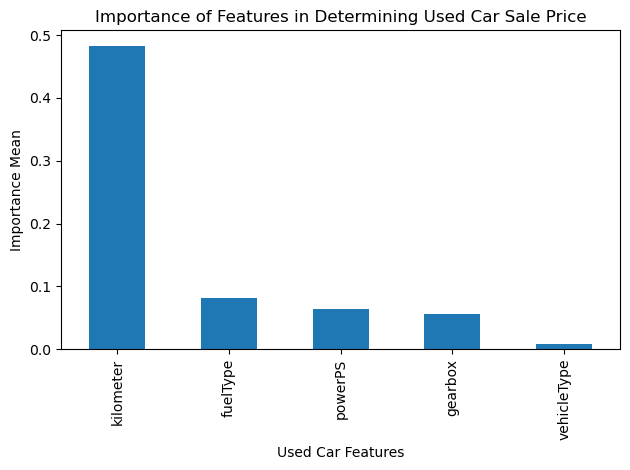

In [71]:
rfe_pipe = Pipeline([('transformer', col_transformer),
                    ('rfe', RFE(estimator=Lasso(), n_features_to_select=8))])

param_dict = {"rfe__n_features_to_select":[2,3,4,5,6,7,8]}
rfe_grid = GridSearchCV(estimator=rfe_pipe, param_grid=param_dict)

rfe_grid.fit(X_train, y_train)

best_estimator = rfe_grid.best_estimator_
compute_importance(best_estimator, X_test, y_test, 30)

# The Price Estimator 

Now we will use our best model to build a price estimator which a used car buyer can use to estimate the price of a car in the market that interests him by simply plugging in the features of the car.

This model will then be hosted on a website for easy access and use. 

Below is a trial run.

In [72]:
# Now let's build a model including only the features that were selected by our best model as impactful on pricing

X_train = X[['kilometer', 'fuelType', 'powerPS', 'gearbox', 'vehicleType']]
y_train = y

X_train['gearbox'] = X_train['gearbox'].map({'manual':0, 'automatic':1})

selector_pipe = Pipeline([('selector', SequentialFeatureSelector(LinearRegression())),
                    ('model', LinearRegression())])

param_dict = {"selector__n_features_to_select":[2,3,4]}
selector_grid = GridSearchCV(estimator=selector_pipe, param_grid=param_dict)

selector_grid.fit(X_train, y_train)

# train our best model with the subset of data
selector_grid.fit(X_train, y_train)

# Predic price for a particular car a customer is interested in 
kilometer = 40000
fuelType = 6 # 6 is the label for petrol
powerPS = 185
gearbox = 1
vehicleType = 7 # 7 is a lable for SUV

estimated_price = selector_grid.predict([[kilometer, fuelType, powerPS, gearbox, vehicleType]])

print(f'The estimated price of the vehicle which has run {kilometer} Kilometers, petrol fueled, power {powerPS}, automatic transmission SUV is: {round(estimated_price[0], 2)}')

The estimated price of the vehicle which has run 40000 Kilometers, petrol fueled, power 185, automatic transmission SUV is: 18245.12


/Users/sriram.rao/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SequentialFeatureSelector was fitted with feature names
  warnings.warn(


# Conclusion

We now a have price estimator tool that uses historical used car price data to provide a used car buy with an estimated price he can safely pay based on the features of the vehicle he has selected.

Note that the car's make, and model did not have significant impact on the pricing. This means the buyer is free to select any make and model of their choice without having to worry about paying a premium for it. 

The tool developed gives the buyer the power to make the car choices without worrying about overpaying!